# KGE TUTORIAL

In this short tutorial, we are going to learn the basics of training KGE models. To do so, we are going to use the **PyKEEN** library, which is built on top of **PyTorch** and contains the most relevant KGE models.

First of all, depending on the size of your KG, some computations could be sped up by using GPUs. Therefore, this tutorial can be run in your Google Colab in order to utilize their free GPU. In order to activate it, in go to *Runtime* ->  *Change Runtime Type* and then select *T4 GPU*. Now, you can use the GPU until you finish the session.

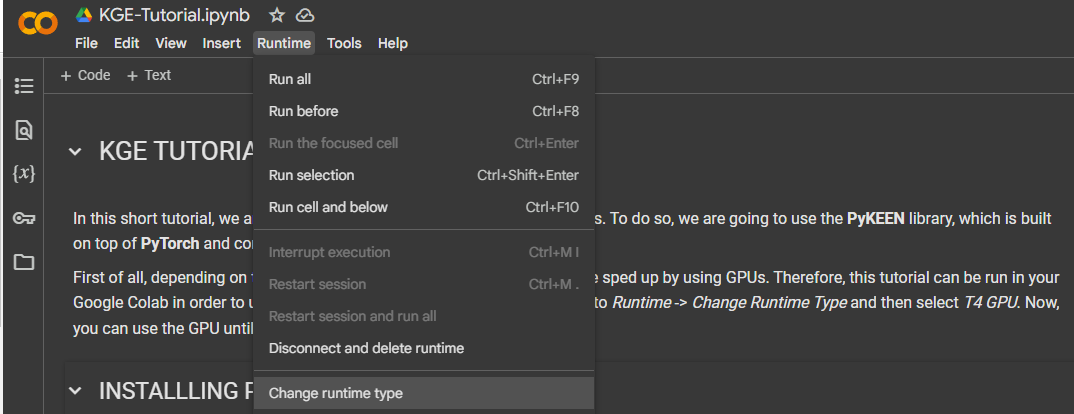

## INSTALLLING PYKEEN

To install *PyKEEN*, you need to run the following code block. Remember that you will need to install it every time you start the Google Collab session. If you are planning to run the scripts locally, you can find PyKEEN's installation guide [here](https://pykeen.readthedocs.io/en/stable/installation.html).

In [ ]:
! pip install --upgrade pip
! python -c "import pykeen" || pip install git+https://github.com/pykeen/pykeen.git

## PyKEEN Toy Example

To get familiar with PYKEEN, we are going to explore a toy example using one of the datasets they provide. There, you will see the basic functionalities, how to configure parameters and how to use the trained model.

In [2]:
import torch
import pykeen
import pandas as pd
from pykeen import predict
from pykeen.datasets import Nations
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

INFO:pykeen.utils:Using opt_einsum


To streamline training KGE models, we will use the *pipeline* function provided in *PyKEEN*. This function allows us to configure the training process with the following parameters:


*   Model: Specifies the KGE model to use. A list of available models in PyKEEN can be found [here](https://pykeen.readthedocs.io/en/stable/reference/models.html).
*   Embedding Dimension: Defines the size of the resulting embedding.
*   Number of Epochs: Determines how many iterations the model will be trained for.
*   Learning Rate: Controls the size of the learning steps.
*   Number of Negative Samples per Positive Sample: Tpecifies how many negative samples each positive triple will be compared against.
*   Random Seed: Ensures reproducibility by allowing you to use the same seed.

Note that these are the simplest parameters to configure when training a model, and they are sufficient for this lab. However, if you are interested, feel free to experiment with additional configurations, such as different negative samplers or learning rate schedulers. You can find more information [here](https://pykeen.readthedocs.io/en/stable/api/pykeen.pipeline.pipeline.html#pykeen.pipeline.pipeline).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


result = pipeline(
    dataset="Nations",
    model="TransE",
    model_kwargs=dict(
        embedding_dim=128,
    ),
    training_kwargs=dict(
        num_epochs=20
    ),
    optimizer_kwargs=dict(
        lr=0.01,
    ),
    negative_sampler_kwargs=dict(
        num_negs_per_pos=1,
    ),
    random_seed=2025,
    device = device
)

Once the model is trained, we can take a look at the evaluation results. Note that PyKEEN provides multiple evaluation metrics, with different ranking procedures (i.e., optimistic, realistic and pessimistic) and different sides ranked (i.e., head, tail and both). You can learn more in PyKEEN's documentation, with the following documents as starting points [[1]](https://pykeen.readthedocs.io/en/stable/api/pykeen.evaluation.RankBasedMetricResults.html)  [[2]](https://pykeen.readthedocs.io/en/stable/reference/metrics.html).

In [ ]:
evaluation = result.metric_results.to_dict()
evaluation['both']['realistic']

Additionally, we can also start playing with the generated embeddings. First of all, you should know that PyKEEN translates each entity and relation into an id. Therefore, if you want to use a specific entity or relation during inference, you must know their associated id. You can find them in the *entity_to_id* and *relation_to_id* dictionaries.

In [ ]:
result.training.relation_to_id

In [ ]:
result.training.entity_to_id

Once we know the ids, we can start using the model. For instance, we could get the score (i.e., the plausibility) the model has given to a triple.

In [ ]:
head_id = result.training.entity_to_id['brazil']
relation_id = result.training.relation_to_id['treaties']
tail_id = result.training.entity_to_id['china']
triple_tensor = torch.tensor([(head_id, relation_id, tail_id)], dtype=torch.long)
print(result.model.score_hrt(triple_tensor))

Moreover, we can be more specific and find which is the element (either an entity if we are asking for the head or the tail, or a relation) that best fits an incomplete triple.

In [ ]:
head_id = result.training.entity_to_id['brazil']
relation_id = result.training.relation_to_id['relexports']


scores = result.model.predict_t(torch.tensor([(head_id, relation_id)], dtype=torch.long))
top_entity_id = torch.argmax(scores).item()
id_to_entity = {v: k for k, v in result.training.entity_to_id.items()}
top_entity_name = id_to_entity.get(top_entity_id)
top_entity_name

Finally, we can also manipulate the actual embeddings. These could serve as an input for a given ML model (e.g., clustering algorithms, recommender systems...).

In [ ]:
embeddings = result.model.entity_representations[0](indices= None).detach()
brazil_id = result.training.entity_to_id['brazil']
print(embeddings[brazil_id])

# USING YOUR OWN DATASET

In this lab, you are going to use your dataset about the academia publication domain, which by now you should already have in **GraphDB**. Currently, there is no direct way to load data from GraphDB to PyKEEN, so we will do it manually. First of all, PyKEEN expects the triples to be in *TSV* format, hence we are going to convert them. Fortunately, this can be directly done from GraphDB when downloading/saving the result of a query. Hence, you can query all the triples on which to create the KGE and store them.


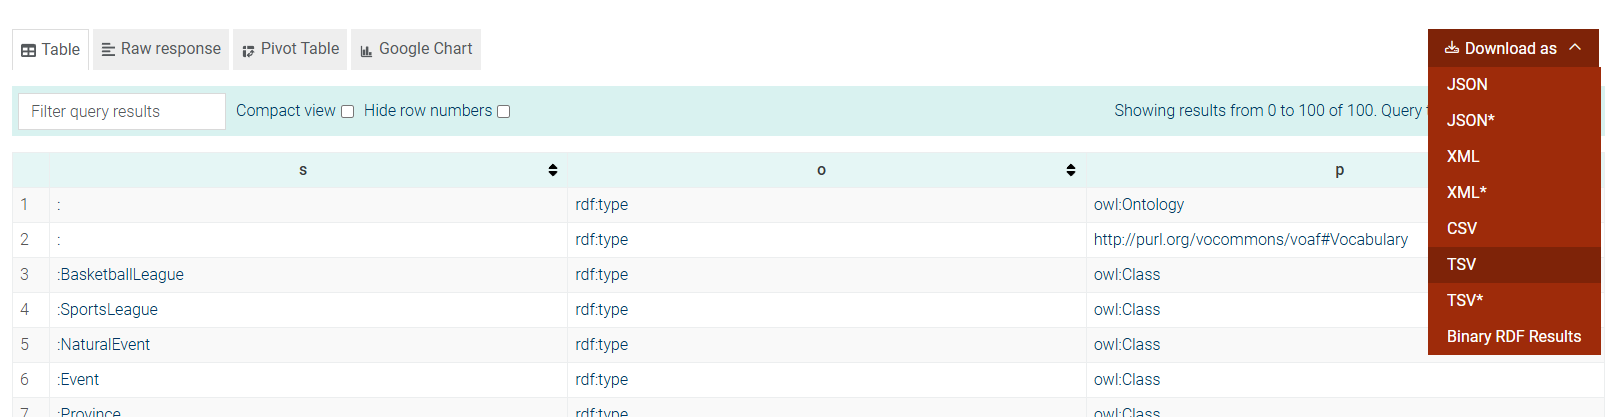


Then, if you are using Google Collab, you will need to upload the file in your Google Drive account and allow Collab to access it. Then, you will need to find the file's path (you can use the navigation in the left-hand size to locate it, and then copy the path).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

When loading the triples, we will rely on the PyKEEN stratification, and perform a simple train|test split. Now, we are ready to train our models as we did with the toy example.

In [ ]:
file_path = 'your_file_path'
tf = TriplesFactory.from_path(file_path)
training, testing = tf.split()

result = pipeline(
    training=training,
    testing=testing,
    model="TransE",
    model_kwargs=dict(
        embedding_dim=128,
    ),
    training_kwargs=dict(
        num_epochs=20
    ),
    optimizer_kwargs=dict(
        lr=0.01,
    ),
    negative_sampler_kwargs=dict(
        num_negs_per_pos=1,
    ),
    random_seed=2025,
    device = device
)

Finally, you may want to store the created models to avoid training them if your session is closed. For that, you can save the model to your directory by using *result.save_to_directory('your_desired_model_name')*. This will create a folder containing  different artifacts, among which the *trained_model.pkl* file will be generated, which can be loaded to get the embeddings and the dictionaries containing  the entities/relations mappings to indices.  

In [ ]:
# STORE

model_name = "your_desired_model_name"
result.save_to_directory(model_name)

#LOAD

pykeen_model = torch.load("./"+ model_name+"/trained_model.pkl")

file_path = "./"+ model_name+'/training_triples/relation_to_id.tsv.gz'
df = pd.read_csv(file_path, sep='\t', compression='gzip', header=0)
rel_to_id = dict(zip(df.iloc[:, 1], df.iloc[:, 0]))
file_path = "./"+ model_name+'/training_triples/entity_to_id.tsv.gz'
df = pd.read_csv(file_path, sep='\t', compression='gzip', header=0)
ent_to_id = dict(zip(df.iloc[:, 1], df.iloc[:, 0]))